# QUESTION 1

### Part 1

In [1]:
import pandas as pd

df = pd.read_csv("dataset_unscaled.csv")
df['date'] = pd.to_datetime(df['date'])

print("\n1. What is the overall average closing price of gold?")
print(df['close'].mean())


print("\n2. What was the highest gold price ever recorded (High column)?")
print(df['high'].max())


print("\n3. On which date did gold have the lowest closing price?")
print(df.loc[df['close'].idxmin()][['date', 'close']])


print("\n4. Which year had the highest average closing price?")
df['year'] = df['date'].dt.year
print(df.groupby('year')['close'].mean().idxmax())


print("\n5. What is the correlation between gold closing price and USD index?")
print(df[['close', 'usd_index']].corr())


print("\n6. How many days did gold close higher than it opened?")
print((df['close'] > df['open']).sum())


print("\n7. Top 5 dates with the highest volume traded:")
print(df.nlargest(5, 'volume')[['date', 'volume']])


print("\n8. Monthly average gold closing price for each month:")
df['month'] = df['date'].dt.month
print(df.groupby('month')['close'].mean())


print("\n9. Dates where gold price dropped more than 1% from previous day:")
df['Return'] = (df['close'] - df['Close_lag1']) / df['Close_lag1']
result = df[df['Return'] < -0.01][['date', 'close', 'Close_lag1', 'Return']]
print(result)


print("\n10. Yearly maximum 'High' gold price:")
print(df.groupby('year')['high'].max())



1. What is the overall average closing price of gold?
2225.000587201196

2. What was the highest gold price ever recorded (High column)?
4049.199951171875

3. On which date did gold have the lowest closing price?
date     2019-04-23 00:00:00
close            1269.300049
Name: 72, dtype: object

4. Which year had the highest average closing price?
2025

5. What is the correlation between gold closing price and USD index?
              close  usd_index
close      1.000000   0.457772
usd_index  0.457772   1.000000

6. How many days did gold close higher than it opened?
12708

7. Top 5 dates with the highest volume traded:
            date    volume
23395 2025-10-10  352500.0
1563  2019-11-26  346362.0
2061  2020-01-29  251274.0
750   2019-07-29  224267.0
3347  2020-07-29  209835.0

8. Monthly average gold closing price for each month:
month
1     2156.955447
2     2060.270821
3     2122.585547
4     2190.090907
5     2084.011412
6     2030.915683
7     2077.048775
8     2134.355330
9    

## Part 2
### correlation matrix and other graphs made in assignment 1

## Part 3

### KNN For Regression


===== KNN RANGE MODEL METRICS =====
Low R2:  -1.2155
High R2: -1.2091
Range Accuracy: 0.79%

===== SAMPLE PREDICTIONS (10 rows) =====
   Pred Low  Actual Close  Pred High
0  0.589655      0.540015   0.545584
1  0.594366      0.540015   0.550691
2  0.575218      0.540015   0.529937
3  0.575851      0.540015   0.530622
4  0.588136      0.540015   0.543938
5  0.645937      0.540015   0.605268
6  0.566778      0.540015   0.520788
7  0.577486      0.540015   0.532395
8  0.578753      0.540015   0.533769
9  0.583499      0.540015   0.538912


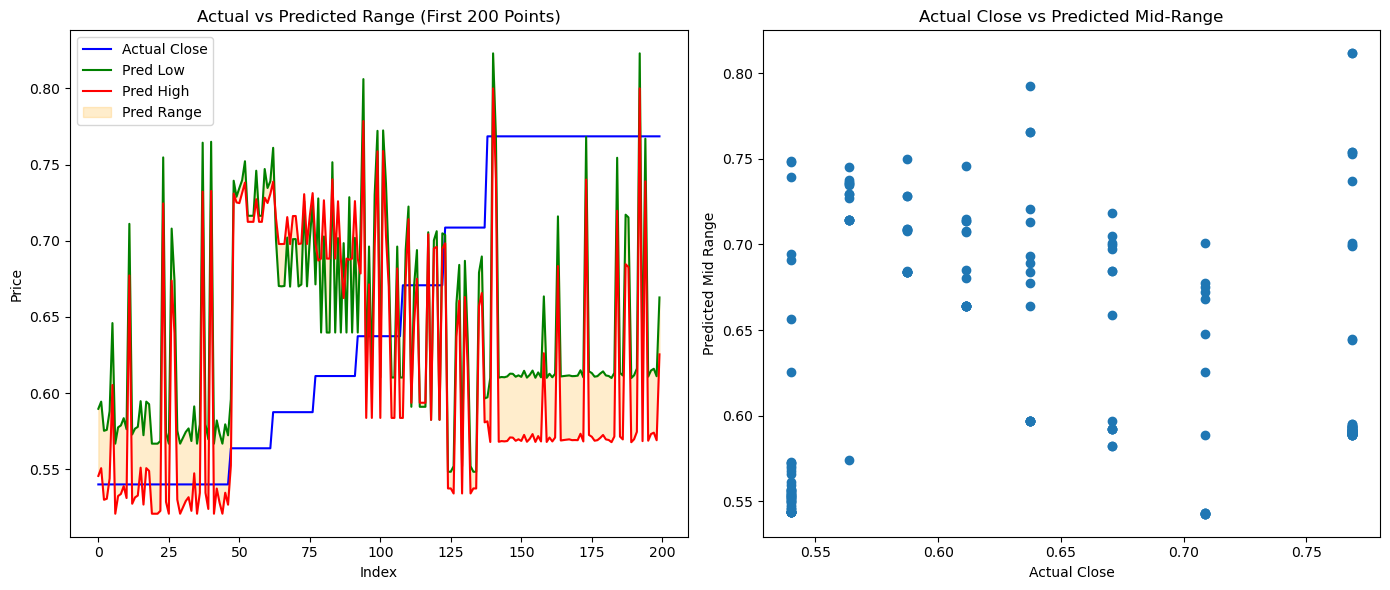

In [13]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_scaled.csv")

#next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

# Feature selection
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

#TRAIN-TEST SPLIT (time series)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

#Train KNN models 
knn_low = KNeighborsRegressor(n_neighbors=5, weights="distance")
knn_high = KNeighborsRegressor(n_neighbors=5, weights="distance")

knn_low.fit(X_train, y_low_train)
knn_high.fit(X_train, y_high_train)

#Predictions
pred_low_knn = knn_low.predict(X_test)
pred_high_knn = knn_high.predict(X_test)

# ---- Range accuracy ----
correct = (
    (y_close_test >= pred_low_knn) &
    (y_close_test <= pred_high_knn)
).sum()

total = len(y_close_test)
range_acc = correct / total

print("\n===== KNN RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_knn):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_knn):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

# ---- Show 10 sample predictions ----
sample = pd.DataFrame({
    "Pred Low": pred_low_knn[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_knn[:10]
})

print("\n===== SAMPLE PREDICTIONS (10 rows) =====")
print(sample)


# Midpoint of predicted range (for scatter plot)
pred_mid = (pred_low_knn + pred_high_knn) / 2

# Plot only first 200 for readability
N = 200
y_close_200 = y_close_test[:N]
pred_low_200 = pred_low_knn[:N]
pred_high_200 = pred_high_knn[:N]
pred_mid_200 = pred_mid[:N]

plt.figure(figsize=(14,6))

# --- Plot 1: Actual close + predicted low/high (range band) ---
plt.subplot(1,2,1)
plt.plot(y_close_200.values, label="Actual Close", color="blue")
plt.plot(pred_low_200, label="Pred Low", color="green")
plt.plot(pred_high_200, label="Pred High", color="red")
plt.fill_between(range(N), pred_low_200, pred_high_200, color="orange", alpha=0.2, label="Pred Range")
plt.title("Actual vs Predicted Range (First 200 Points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

# --- Plot 2: Scatter of actual close vs midpoint of predicted range ---
plt.subplot(1,2,2)
plt.scatter(y_close_200, pred_mid_200)
plt.title("Actual Close vs Predicted Mid-Range")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Mid Range")

plt.tight_layout()
plt.show()


## Decision Tree (Regression)


===== DECISION TREE RANGE MODEL METRICS =====
Low R2:  -0.6089
High R2: -0.6538
Range Accuracy: 24.34%

===== SAMPLE PREDICTIONS (10 rows) =====
      Pred Low  Actual Close    Pred High
0  2565.699951   2565.699951  2565.699951
1  2565.699951   2565.699951  2565.699951
2  2565.699951   2565.699951  2565.699951
3  2565.699951   2565.699951  2565.699951
4  2565.699951   2565.699951  2565.699951
5  2565.699951   2565.699951  2565.699951
6  2565.699951   2565.699951  2565.699951
7  2565.699951   2565.699951  2565.699951
8  2565.699951   2565.699951  2565.699951
9  2565.699951   2565.699951  2565.699951


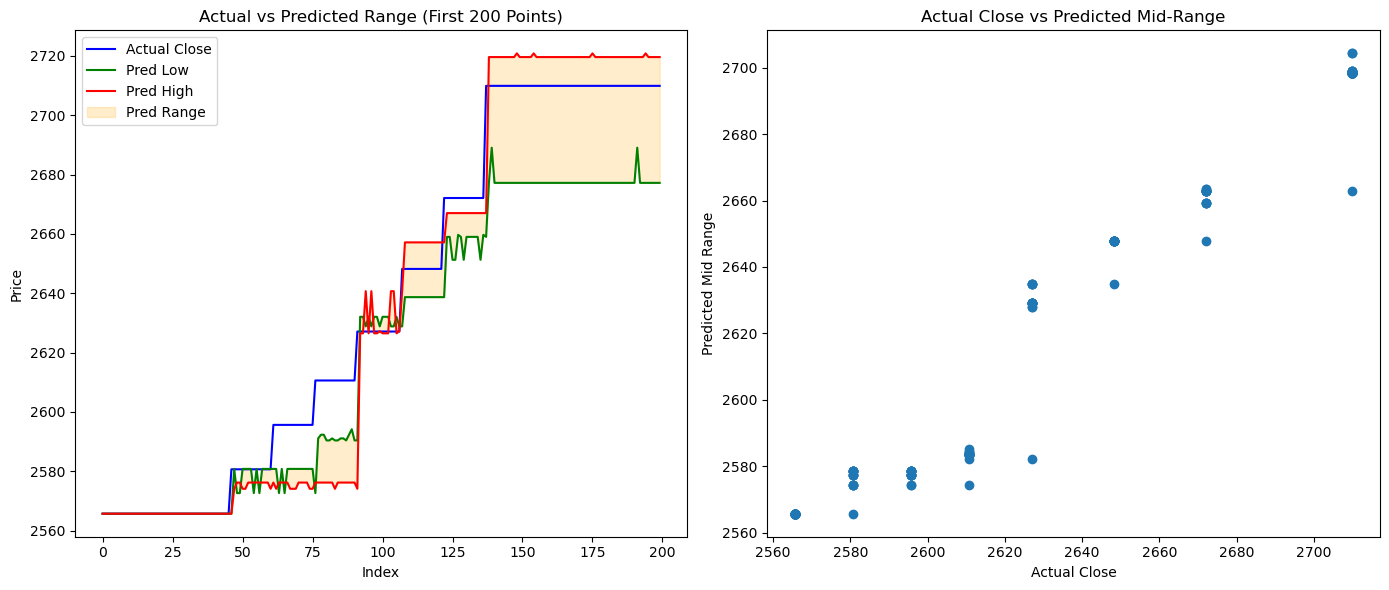

In [15]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("dataset_unscaled.csv")

# --- Create next-day targets ---
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

# Feature selection: all numeric except targets
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# ---- TRAIN-TEST SPLIT (time series) ----
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

# ---- Train Decision Tree models ----
tree_low = DecisionTreeRegressor(
    max_depth=10,          # you can tune this
    min_samples_leaf=5     # prevents overfitting
)

tree_high = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=5
)

tree_low.fit(X_train, y_low_train)
tree_high.fit(X_train, y_high_train)

# ---- Predictions ----
pred_low_dt= tree_low.predict(X_test)
pred_high_dt = tree_high.predict(X_test)

# ---- Range accuracy ----
correct = ((y_close_test >= pred_low_dt) & (y_close_test <= pred_high_dt)).sum()
total = len(y_close_test)

range_acc = correct / total

print("\n===== DECISION TREE RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_dt):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_dt):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

# ---- Show 10 sample predictions ----
sample = pd.DataFrame({
    "Pred Low": pred_low_dt[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_dt[:10]
})

print("\n===== SAMPLE PREDICTIONS (10 rows) =====")
print(sample)


# Midpoint of predicted range
pred_mid = (pred_low_dt + pred_high_dt) / 2

# Plot only first 200 for readability
N = 200
y_close_200 = y_close_test[:N]
pred_low_200 = pred_low_dt[:N]
pred_high_200 = pred_high_dt[:N]
pred_mid_200 = pred_mid[:N]

plt.figure(figsize=(14,6))

# --- Plot 1: Actual close + predicted low/high (range band) ---
plt.subplot(1,2,1)
plt.plot(y_close_200.values, label="Actual Close", color="blue")
plt.plot(pred_low_200, label="Pred Low", color="green")
plt.plot(pred_high_200, label="Pred High", color="red")
plt.fill_between(range(N), pred_low_200, pred_high_200, color="orange", alpha=0.2, label="Pred Range")

plt.title("Actual vs Predicted Range (First 200 Points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

# --- Plot 2: Scatter of actual close vs midpoint of predicted range ---
plt.subplot(1,2,2)
plt.scatter(y_close_200, pred_mid_200)
plt.title("Actual Close vs Predicted Mid-Range")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Mid Range")

plt.tight_layout()
plt.show()


## SVM


===== SVM RANGE MODEL METRICS =====
Low R2:  -2.6845
High R2: -2.5525
Range Accuracy: 0.36%

SAMPLE PREDICTIONS (10 rows)
   Pred Low  Actual Close  Pred High
0  0.571429      0.540015   0.523151
1  0.566474      0.540015   0.521109
2  0.573564      0.540015   0.517570
3  0.572824      0.540015   0.519779
4  0.563700      0.540015   0.513287
5  0.576978      0.540015   0.532477
6  0.568899      0.540015   0.512608
7  0.572830      0.540015   0.520041
8  0.571407      0.540015   0.520086
9  0.572203      0.540015   0.517278


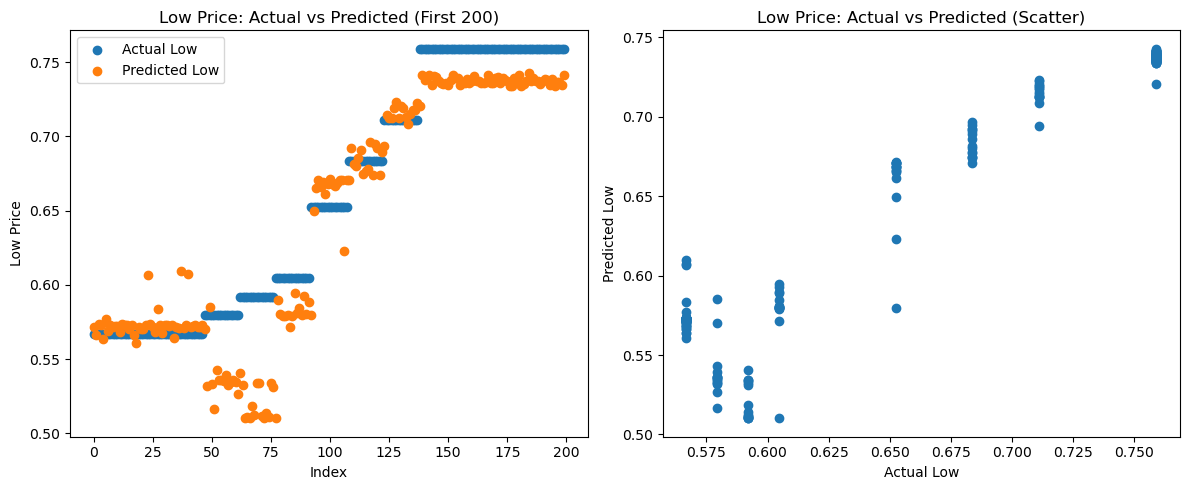

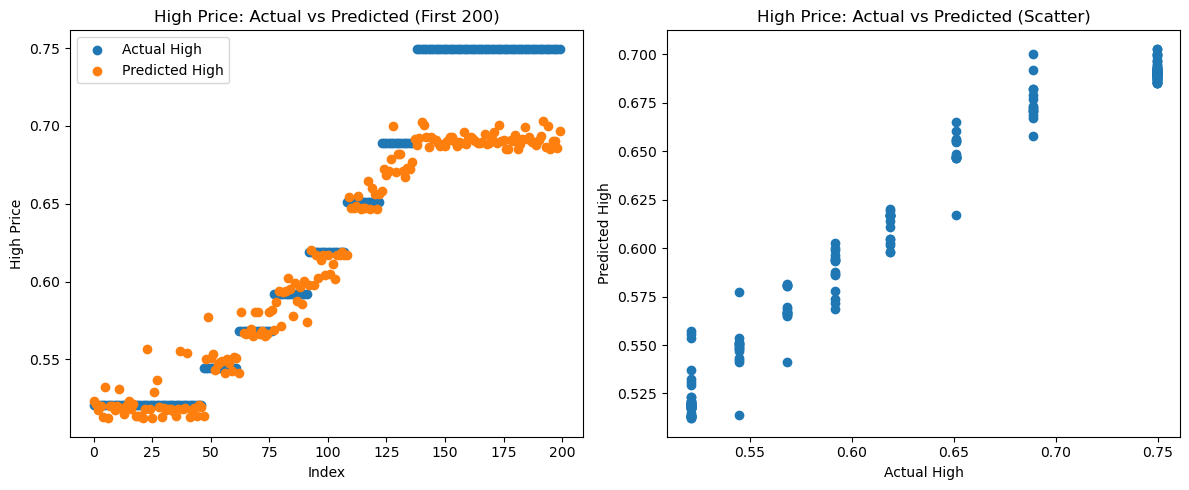

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# ---------------------------
# LOAD DATA (scaled)
# ---------------------------
df = pd.read_csv("dataset_scaled.csv")

# next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# drop last row because of shift
df = df.iloc[:-1]

# FEATURES: all numeric except targets
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# TIME-SERIES TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

# ---------------------------
# SVM MODELS
# ---------------------------
# SVR with RBF kernel (good default for regression)
low_model = SVR(kernel="rbf", C=100, epsilon=0.01)
high_model = SVR(kernel="rbf", C=100, epsilon=0.01)

# TRAIN
low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)

# PREDICTIONS
pred_low_svm = low_model.predict(X_test)
pred_high_svm = high_model.predict(X_test)

# ---------------------------
# RANGE ACCURACY
# ---------------------------
correct = ((y_close_test >= pred_low_svm) & (y_close_test <= pred_high_svm)).sum()
range_acc = correct / len(y_close_test)

# ---------------------------
# METRICS
# ---------------------------
print("\n===== SVM RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_svm):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_svm):.4f}")
print(f"Range Accuracy: {range_acc* 100:.2f}%")

# SAMPLE OUTPUT
sample = pd.DataFrame({
    "Pred Low": pred_low_svm[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_svm[:10]
})
print("\nSAMPLE PREDICTIONS (10 rows)")
print(sample)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_low_test[:200])), y_low_test[:200], label="Actual Low")
plt.scatter(range(len(pred_low_svm[:200])), pred_low_svm[:200], label="Predicted Low")
plt.title("Low Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("Low Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_low_test[:200], pred_low_svm[:200])
plt.title("Low Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual Low")
plt.ylabel("Predicted Low")

plt.tight_layout()
plt.show()


# ---------------------------
# VISUALIZATION — HIGH
# ---------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_high_test[:200])), y_high_test[:200], label="Actual High")
plt.scatter(range(len(pred_high_svm[:200])), pred_high_svm[:200], label="Predicted High")
plt.title("High Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("High Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_high_test[:200], pred_high_svm[:200])
plt.title("High Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual High")
plt.ylabel("Predicted High")

plt.tight_layout()
plt.show()


## Enssemble Learning Algorithms


===== RANGE MODEL METRICS =====
Low R2:  -0.6620
High R2: -0.7057
Range Accuracy: 21.16%

SAMPLE PREDICTIONS (10 rows) 
      Pred Low  Actual Close    Pred High
0  2565.254805   2565.699951  2565.510344
1  2565.252958   2565.699951  2566.986374
2  2565.256502   2565.699951  2565.824208
3  2565.256502   2565.699951  2565.510344
4  2565.256502   2565.699951  2565.766541
5  2565.256502   2565.699951  2565.510344
6  2565.256502   2565.699951  2566.015058
7  2565.256502   2565.699951  2565.510344
8  2565.252958   2565.699951  2565.510344
9  2565.256502   2565.699951  2565.510344


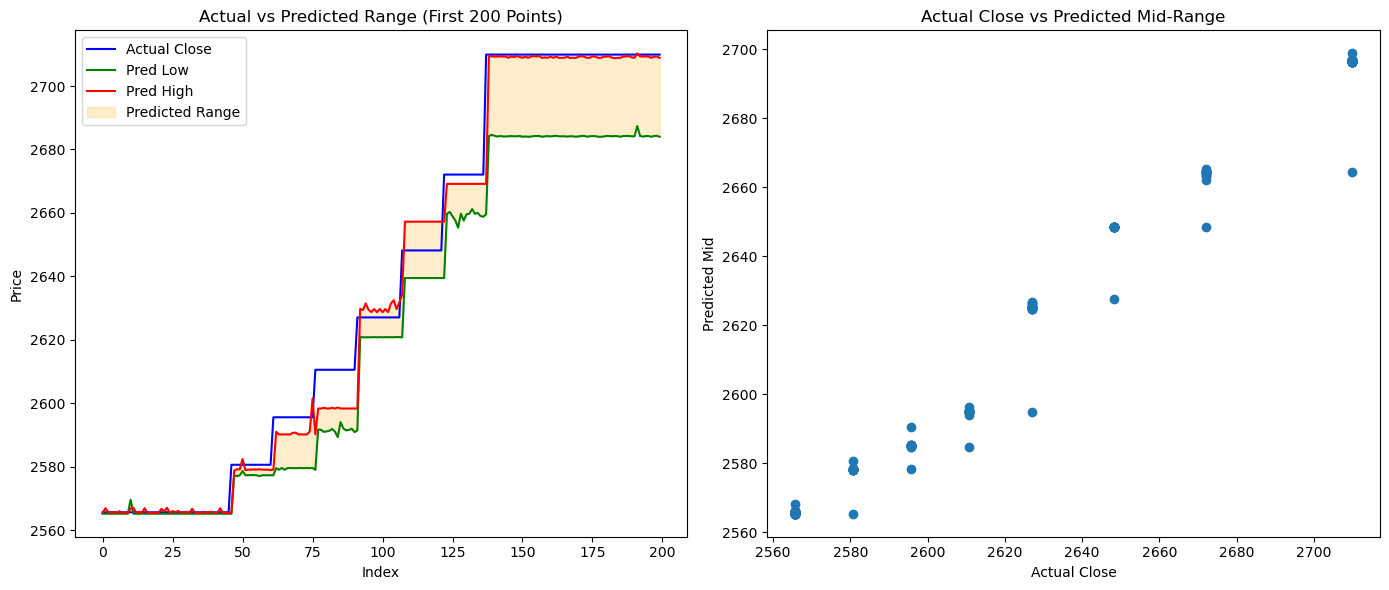

In [8]:
#random forest

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_unscaled.csv")

# next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

# Feature selection
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# TRAIN-TEST SPLIT (time series)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

# Train models
low_model = RandomForestRegressor(n_estimators=300, max_depth=8)
high_model = RandomForestRegressor(n_estimators=300, max_depth=8)

low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)

# Predictions
pred_low_rf = low_model.predict(X_test)
pred_high_rf = high_model.predict(X_test)

# Range accuracy
correct = ((y_close_test >= pred_low_rf) & (y_close_test <= pred_high_rf)).sum()
total = len(y_close_test)
range_acc = correct / total

print("\n===== RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_rf):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_rf):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

# 10 sample predictions
sample = pd.DataFrame({
    "Pred Low": pred_low_rf[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_rf[:10]
})

print("\nSAMPLE PREDICTIONS (10 rows) ")
print(sample)

# midpoint of predicted range
pred_mid = (pred_low_rf + pred_high_rf) / 2

N = 200  # first 200 points

y_close_200 = y_close_test[:N]
pred_low_200 = pred_low_rf[:N]
pred_high_200 = pred_high_rf[:N]
pred_mid_200 = pred_mid[:N]

plt.figure(figsize=(14,6))

# --- Plot 1: actual vs predicted range
plt.subplot(1,2,1)
plt.plot(y_close_200.values, label="Actual Close", color="blue")
plt.plot(pred_low_200, label="Pred Low", color="green")
plt.plot(pred_high_200, label="Pred High", color="red")
plt.fill_between(range(N), pred_low_200, pred_high_200, alpha=0.2, color="orange", label="Predicted Range")

plt.title("Actual vs Predicted Range (First 200 Points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

# --- Plot 2: scatter actual vs predicted mid-range
plt.subplot(1,2,2)
plt.scatter(y_close_200, pred_mid_200)
plt.title("Actual Close vs Predicted Mid-Range")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Mid")

plt.tight_layout()
plt.show()



===== XGBOOST RANGE MODEL METRICS =====
Low R2:  -0.7002
High R2: -0.7421
Range Accuracy: 14.58%

SAMPLE PREDICTIONS (10 rows)
      Pred Low  Actual Close    Pred High
0  2564.868164   2565.699951  2566.830566
1  2553.528809   2565.699951  2546.048584
2  2564.989502   2565.699951  2566.296875
3  2565.122559   2565.699951  2566.722656
4  2564.971924   2565.699951  2566.541260
5  2564.896729   2565.699951  2566.674561
6  2565.056396   2565.699951  2566.516602
7  2565.314697   2565.699951  2566.336426
8  2564.449951   2565.699951  2564.753906
9  2565.054688   2565.699951  2566.266113


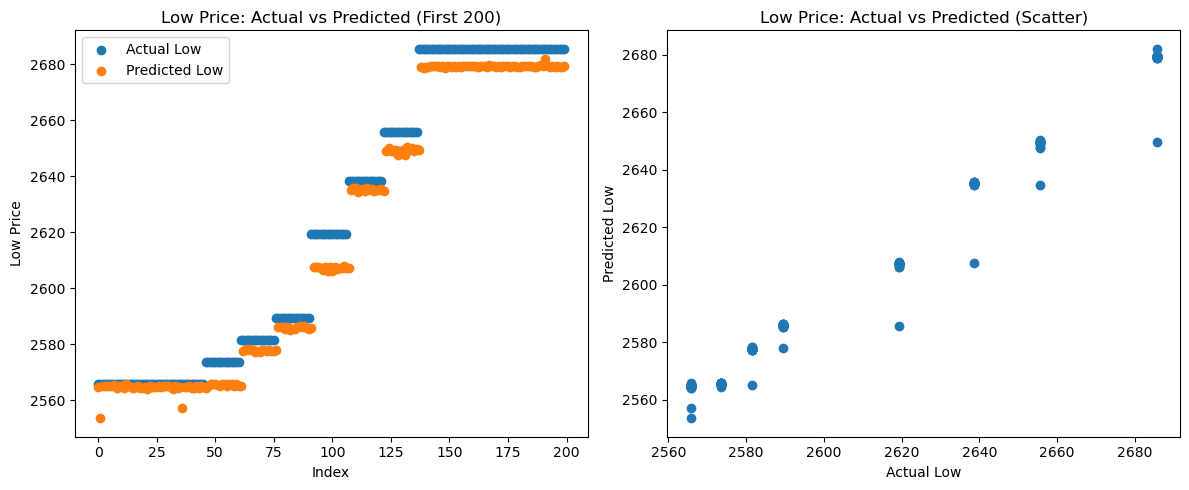

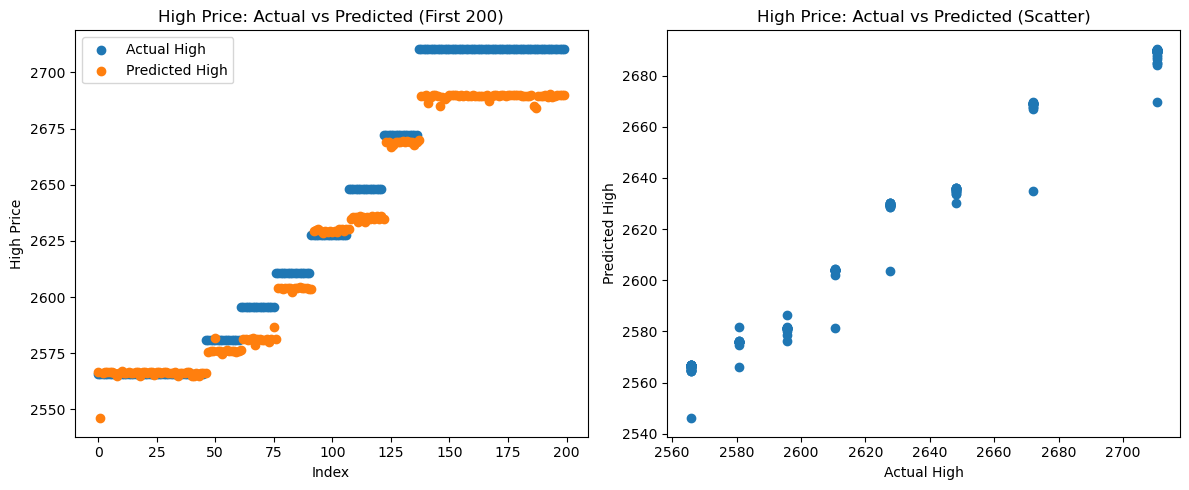

In [7]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ---------------------------
# LOAD DATA
# ---------------------------
df = pd.read_csv("dataset_unscaled.csv")

df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

df = df.iloc[:-1]

# FEATURES
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# TIME SPLIT
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

# ---------------------------
# TRAIN XGBOOST MODELS
# ---------------------------
low_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

high_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)

# ---------------------------
# PREDICTIONS
# ---------------------------
pred_low_xgb = low_model.predict(X_test)
pred_high_xgb = high_model.predict(X_test)

# RANGE ACCURACY
correct = ((y_close_test >= pred_low_xgb) & (y_close_test <= pred_high_xgb)).sum()
total = len(y_close_test)
range_acc = correct / total

# ---------------------------
# METRICS
# ---------------------------
print("\n===== XGBOOST RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_xgb):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_xgb):.4f}")
print(f"Range Accuracy: {range_acc* 100:.2f}%")

# SAMPLE
sample = pd.DataFrame({
    "Pred Low": pred_low_xgb[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_xgb[:10]
})
print("\nSAMPLE PREDICTIONS (10 rows)")
print(sample)


# Plot: Actual vs Predicted LOW
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(range(len(y_low_test[:200])), y_low_test[:200], label="Actual Low")
plt.scatter(range(len(pred_low_xgb[:200])), pred_low_xgb[:200], label="Predicted Low")
plt.title("Low Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("Low Price")
plt.legend()

# Scatter plot actual vs predicted low
plt.subplot(1,2,2)
plt.scatter(y_low_test[:200], pred_low_xgb[:200])
plt.title("Low Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual Low")
plt.ylabel("Predicted Low")

plt.tight_layout()
plt.show()


# Plot: Actual vs Predicted HIGH
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(range(len(y_high_test[:200])), y_high_test[:200], label="Actual High")
plt.scatter(range(len(pred_high_xgb[:200])), pred_high_xgb[:200], label="Predicted High")
plt.title("High Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("High Price")
plt.legend()

# Scatter plot actual vs predicted high
plt.subplot(1,2,2)
plt.scatter(y_high_test[:200], pred_high_xgb[:200])
plt.title("High Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual High")
plt.ylabel("Predicted High")

plt.tight_layout()
plt.show()



===== ADA BOOST RANGE MODEL METRICS =====
Low R2:  -0.7355
High R2: -0.7357
Range Accuracy: 20.47%

SAMPLE PREDICTIONS (10 rows) 
      Pred Low  Actual Close    Pred High
0  2565.413951   2565.699951  2575.086246
1  2565.413951   2565.699951  2575.086246
2  2565.413951   2565.699951  2575.086246
3  2565.413951   2565.699951  2575.086246
4  2565.413951   2565.699951  2575.086246
5  2565.413951   2565.699951  2575.086246
6  2565.413951   2565.699951  2575.086246
7  2565.413951   2565.699951  2575.086246
8  2565.413951   2565.699951  2575.086246
9  2565.413951   2565.699951  2575.086246


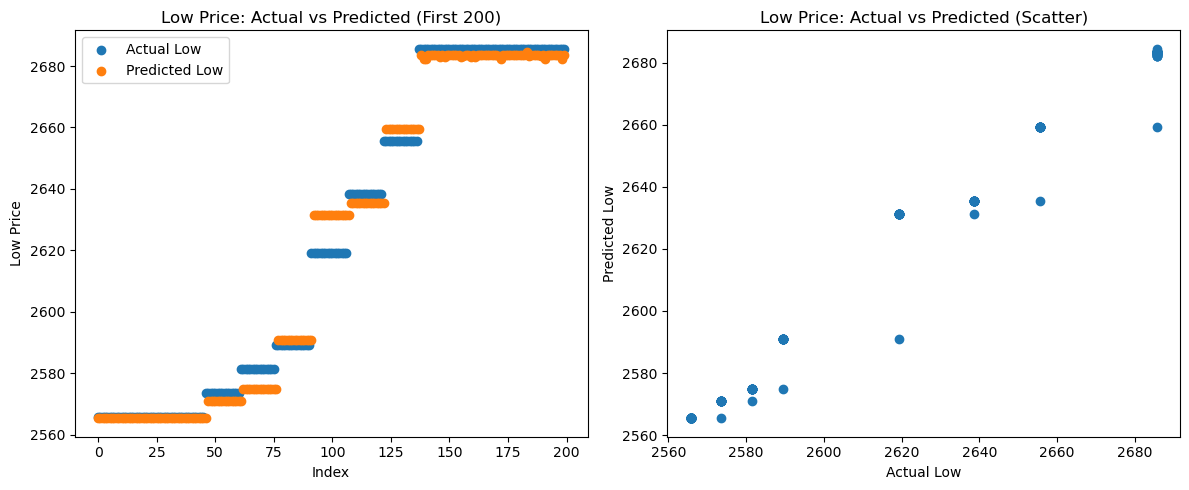

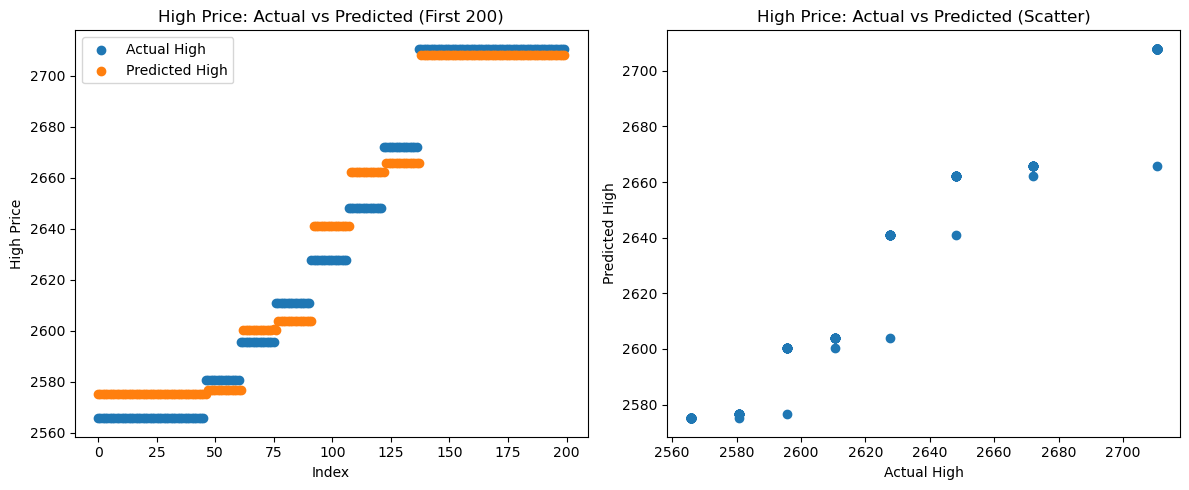

In [2]:
#Adaboost

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# ---------------------------
# LOAD DATA
# ---------------------------
df = pd.read_csv("dataset_unscaled.csv")

# next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

df = df.iloc[:-1]

# FEATURES
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# TIME SPLIT
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]


# ---------------------------
# ADA BOOST MODELS
# ---------------------------

# Weak learner (base estimator)
base = DecisionTreeRegressor(max_depth=5)

low_model = AdaBoostRegressor(
    estimator=base,
    n_estimators=300,
    learning_rate=0.05,
    loss='linear'
)

high_model = AdaBoostRegressor(
    estimator=base,
    n_estimators=300,
    learning_rate=0.05,
    loss='linear'
)

# Train
low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)


# ---------------------------
# PREDICTIONS
# ---------------------------
pred_low_ada= low_model.predict(X_test)
pred_high_ada = high_model.predict(X_test)

# RANGE ACCURACY
correct = ((y_close_test >= pred_low_ada) & (y_close_test <= pred_high_ada)).sum()
range_acc = correct / len(y_close_test)


print("\n===== ADA BOOST RANGE MODEL METRICS =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_ada):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_ada):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

# SAMPLE OUTPUT
sample = pd.DataFrame({
    "Pred Low": pred_low_ada[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_ada[:10]
})
print("\nSAMPLE PREDICTIONS (10 rows) ")
print(sample)


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_low_test[:200])), y_low_test[:200], label="Actual Low")
plt.scatter(range(len(pred_low_ada[:200])), pred_low_ada[:200], label="Predicted Low")
plt.title("Low Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("Low Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_low_test[:200], pred_low_ada[:200])
plt.title("Low Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual Low")
plt.ylabel("Predicted Low")

plt.tight_layout()
plt.show()


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_high_test[:200])), y_high_test[:200], label="Actual High")
plt.scatter(range(len(pred_high_ada[:200])), pred_high_ada[:200], label="Predicted High")
plt.title("High Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("High Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_high_test[:200], pred_high_ada[:200])
plt.title("High Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual High")
plt.ylabel("Predicted High")

plt.tight_layout()
plt.show()


## Linear Regression


LINEAR REGRESSION RANGE MODEL METRICS
Low R2:  0.9998
High R2: 0.9999
Range Accuracy: 94.64%

 SAMPLE PREDICTIONS (10 rows) 
      Pred Low  Actual Close    Pred High
0  2565.498757   2565.699951  2566.153608
1  2565.344672   2565.699951  2565.973422
2  2565.325831   2565.699951  2565.963601
3  2565.429352   2565.699951  2566.095818
4  2565.350889   2565.699951  2566.018404
5  2565.435125   2565.699951  2566.090074
6  2565.321664   2565.699951  2565.960525
7  2565.369732   2565.699951  2566.004094
8  2565.380495   2565.699951  2566.011498
9  2565.381189   2565.699951  2566.007365


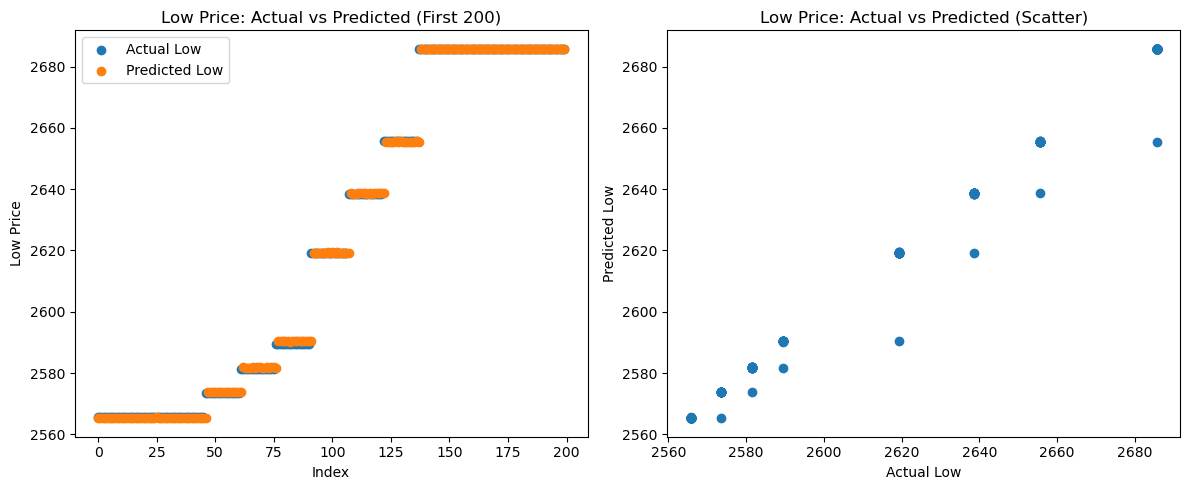

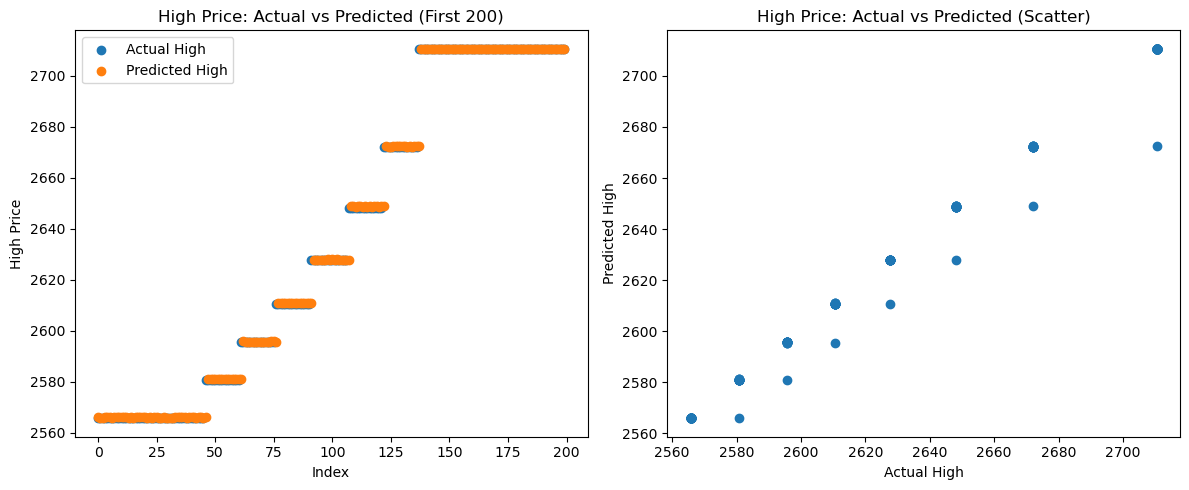

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv("dataset_unscaled.csv")

# next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# drop last row because of shift
df = df.iloc[:-1]

# FEATURES
features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features]
y_low = df["low_next"]
y_high = df["high_next"]
y_close = df["close_next"]

# TIME-SERIES TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

low_model = LinearRegression()
high_model = LinearRegression()

# TRAIN
low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)

# PREDICTIONS
pred_low_lr = low_model.predict(X_test)
pred_high_lr = high_model.predict(X_test)

correct = ((y_close_test >= pred_low_lr) & (y_close_test <= pred_high_lr)).sum()
range_acc = correct / len(y_close_test)


print("\nLINEAR REGRESSION RANGE MODEL METRICS")
print(f"Low R2:  {r2_score(y_low_test, pred_low_lr):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_lr):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

sample = pd.DataFrame({
    "Pred Low": pred_low_lr[:10],
    "Actual Close": y_close_test[:10].values,
    "Pred High": pred_high_lr[:10]
})
print("\n SAMPLE PREDICTIONS (10 rows) ")
print(sample)


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_low_test[:200])), y_low_test[:200], label="Actual Low")
plt.scatter(range(len(pred_low_lr[:200])), pred_low_lr[:200], label="Predicted Low")
plt.title("Low Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("Low Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_low_test[:200], pred_low_lr[:200])
plt.title("Low Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual Low")
plt.ylabel("Predicted Low")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(range(len(y_high_test[:200])), y_high_test[:200], label="Actual High")
plt.scatter(range(len(pred_high_lr[:200])), pred_high_lr[:200], label="Predicted High")
plt.title("High Price: Actual vs Predicted (First 200)")
plt.xlabel("Index")
plt.ylabel("High Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_high_test[:200], pred_high_lr[:200])
plt.title("High Price: Actual vs Predicted (Scatter)")
plt.xlabel("Actual High")
plt.ylabel("Predicted High")

plt.tight_layout()
plt.show()


## K Means Clustering

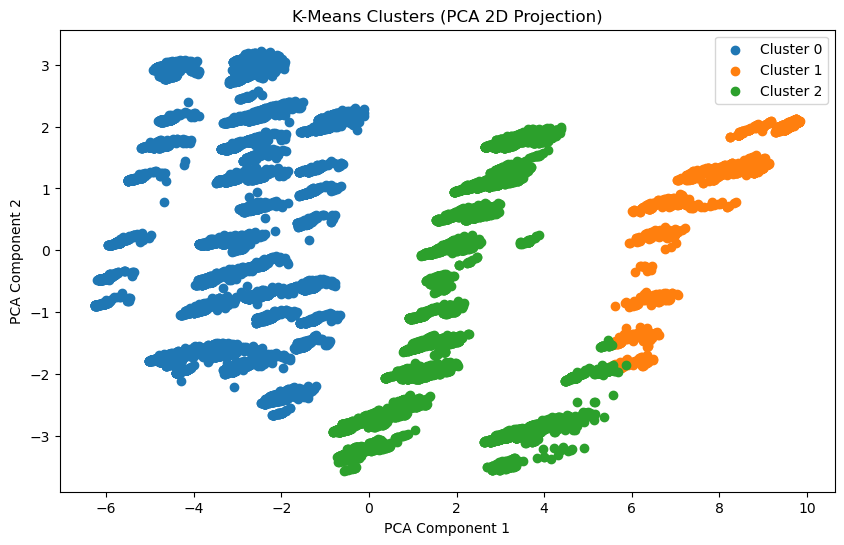


===== CLUSTER SUMMARY =====
              low                                    high                      \
             mean       std       min       max      mean       std       min   
cluster                                                                         
0       -0.727870  0.292547 -1.517180 -0.233647 -0.727020  0.291015 -1.526948   
1        2.453819  0.437599  1.451381  2.846031  2.455014  0.437902  1.473470   
2        0.403636  0.455491 -0.364645  1.770942  0.402290  0.458218 -0.383382   

                      close                                
              max      mean       std       min       max  
cluster                                                    
0       -0.167374 -0.726232  0.290220 -1.514347 -0.226647  
1        2.864964  2.461990  0.447170  1.449932  2.881520  
2        1.781247  0.399781  0.452642 -0.371802  1.778869  

Sample days in Cluster 0:
      close      low      high
0 -1.480594 -1.47998 -1.489656
1 -1.480594 -1.47998 -1.489656
2 -1

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# -----------------------------
# 1. Load scaled dataset
# -----------------------------
df = pd.read_csv("dataset_scaled.csv")  # already scaled
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# optionally drop target/price if you don't want it to influence clusters
features_to_use = [f for f in numeric_features if f not in ['close', 'low', 'high']]

X = df[features_to_use].values

# -----------------------------
# 2. Apply K-Means clustering
# -----------------------------
k = 3  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# -----------------------------
# 3. Apply PCA for 2D visualization
# -----------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
for cluster in range(k):
    plt.scatter(
        X_pca[df['cluster'] == cluster, 0],
        X_pca[df['cluster'] == cluster, 1],
        label=f"Cluster {cluster}"
    )

plt.title("K-Means Clusters (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# -----------------------------
# 4. Analyze clusters
# -----------------------------
cluster_summary = df.groupby('cluster')[['low','high','close']].agg(['mean','std','min','max'])
print("\n===== CLUSTER SUMMARY =====")
print(cluster_summary)

# -----------------------------
# 5. Optional: Sample some cluster members
# -----------------------------
for cluster in range(k):
    print(f"\nSample days in Cluster {cluster}:")
    print(df[df['cluster']==cluster][['close','low','high']].head(5))


## Neural Network Perceptron

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Low R2:  0.9627
High R2: -0.8721
Range Accuracy: 48.90%


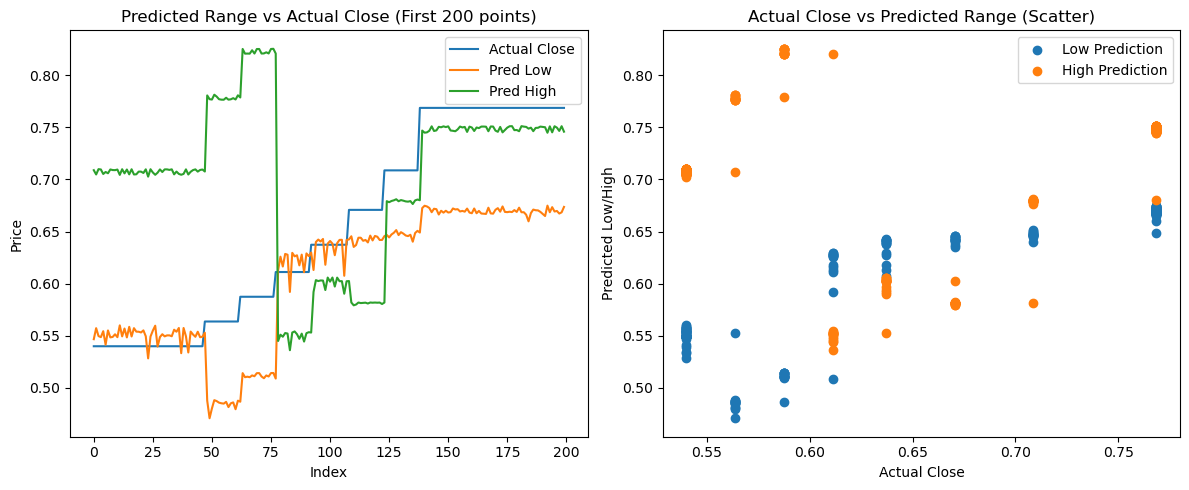

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

df = pd.read_csv("dataset_scaled.csv")

# --- Create next-day targets ---
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features].values
y_low = df["low_next"].values
y_high = df["high_next"].values
y_close = df["close_next"].values


# Reduce to top N components 
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

train_size = int(len(X_pca) * 0.8)
X_train, X_test = X_pca[:train_size], X_pca[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]


# Build MLP model
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

low_model = build_mlp(X_train.shape[1])
high_model = build_mlp(X_train.shape[1])

# Train models
low_model.fit(X_train, y_low_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
high_model.fit(X_train, y_high_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)

pred_low_nn = low_model.predict(X_test).flatten()
pred_high_nn = high_model.predict(X_test).flatten()

correct = ((y_close_test >= pred_low_nn) & (y_close_test <= pred_high_nn)).sum()
range_acc = correct / len(y_close_test)

print(f"Low R2:  {r2_score(y_low_test, pred_low_nn):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_nn):.4f}")
print(f"Range Accuracy: {range_acc * 100:.2f}%")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(len(y_close_test[:200])), y_close_test[:200], label="Actual Close")
plt.plot(range(len(pred_low_nn[:200])), pred_low_nn[:200], label="Pred Low")
plt.plot(range(len(pred_high_nn[:200])), pred_high_nn[:200], label="Pred High")
plt.title("Predicted Range vs Actual Close (First 200 points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_close_test[:200], pred_low_nn[:200], label="Low Prediction")
plt.scatter(y_close_test[:200], pred_high_nn[:200], label="High Prediction")
plt.title("Actual Close vs Predicted Range (Scatter)")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Low/High")
plt.legend()

plt.tight_layout()
plt.show()


## Gradient Descent


===== GRADIENT DESCENT RANGE MODEL =====
Low R2:  0.9549
High R2: 0.9491
Range Accuracy: 0.00%


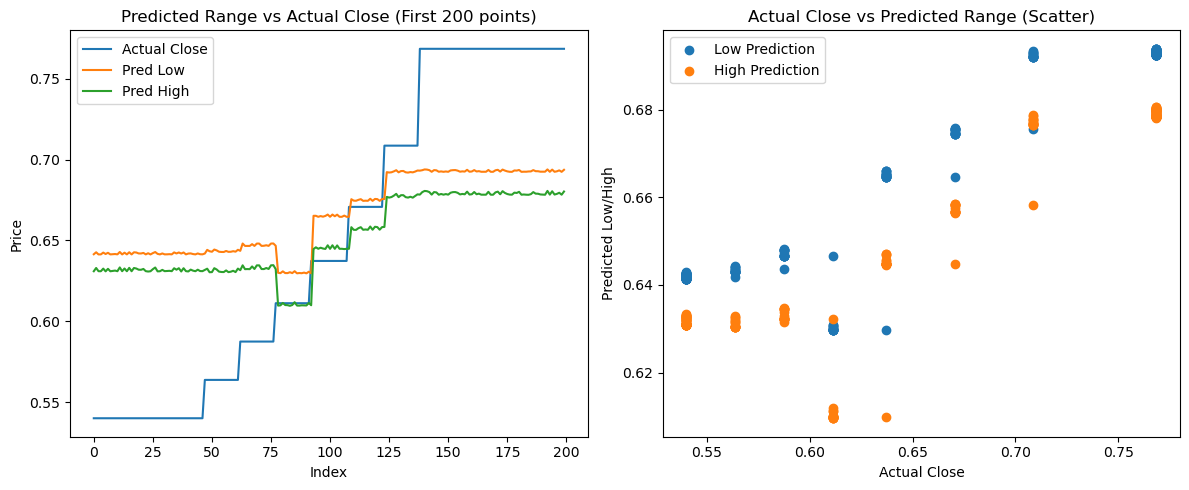

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

df = pd.read_csv("dataset_scaled.csv")

# Create next-day targets
df["low_next"] = df["low"].shift(-1)
df["high_next"] = df["high"].shift(-1)
df["close_next"] = df["close"].shift(-1)

# Drop last row (because of shift)
df = df.iloc[:-1]

features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in ["low_next", "high_next", "close_next", "close"]:
    if col in features:
        features.remove(col)

X = df[features].values
y_low = df["low_next"].values
y_high = df["high_next"].values
y_close = df["close_next"].values

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

# Train-test split (time series)

train_size = int(len(X_pca) * 0.8)
X_train, X_test = X_pca[:train_size], X_pca[train_size:]
y_low_train, y_low_test = y_low[:train_size], y_low[train_size:]
y_high_train, y_high_test = y_high[:train_size], y_high[train_size:]
y_close_test = y_close[train_size:]

class LinearRegressorGD:
    def __init__(self, lr=0.001, epochs=5000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.X = np.c_[np.ones(X.shape[0]), X]  # add bias term
        self.y = y.reshape(-1,1)
        self.theta = np.zeros((self.X.shape[1], 1))
        
        for _ in range(self.epochs):
            predictions = self.X @ self.theta
            error = predictions - self.y
            gradient = (self.X.T @ error) / len(self.y)
            self.theta -= self.lr * gradient

    def predict(self, X):
        X_ = np.c_[np.ones(X.shape[0]), X]
        return (X_ @ self.theta).flatten()

#Train separate GD models
low_model = LinearRegressorGD(lr=0.01, epochs=5000)
high_model = LinearRegressorGD(lr=0.01, epochs=5000)

low_model.fit(X_train, y_low_train)
high_model.fit(X_train, y_high_train)

pred_low_gd = low_model.predict(X_test)
pred_high_gd = high_model.predict(X_test)

correct = ((y_close_test >= pred_low_gd) & (y_close_test <= pred_high_gd)).sum()
range_acc = correct / len(y_close_test)

#Evaluation metrics
print("\n===== GRADIENT DESCENT RANGE MODEL =====")
print(f"Low R2:  {r2_score(y_low_test, pred_low_gd):.4f}")
print(f"High R2: {r2_score(y_high_test, pred_high_gd):.4f}")
print(f"Range Accuracy: {range_acc* 100:.2f}%")

# Visualization
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(len(y_close_test[:200])), y_close_test[:200], label="Actual Close")
plt.plot(range(len(pred_low_gd[:200])), pred_low_gd[:200], label="Pred Low")
plt.plot(range(len(pred_high_gd[:200])), pred_high_gd[:200], label="Pred High")
plt.title("Predicted Range vs Actual Close (First 200 points)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_close_test[:200], pred_low_gd[:200], label="Low Prediction")
plt.scatter(y_close_test[:200], pred_high_gd[:200], label="High Prediction")
plt.title("Actual Close vs Predicted Range (Scatter)")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Low/High")
plt.legend()

plt.tight_layout()
plt.show()


### Comparisons


===== MODEL COMPARISON =====
               Model     Low R2    High R2       MSE Low      MSE High
0      Random Forest  -0.662019  -0.705716  4.693383e+05  4.989160e+05
1                KNN -36.060637 -35.681032  1.046557e+07  1.072907e+07
2      Decision Tree  -0.608942  -0.653842  4.543498e+05  4.837430e+05
3                SVM -36.067334 -35.686867  1.046746e+07  1.073078e+07
4            XGBoost  -0.700247  -0.742129  4.801335e+05  5.095666e+05
5           AdaBoost  -0.735493  -0.735666  4.900865e+05  5.076761e+05
6  Linear Regression   0.999829   0.999853  4.821234e+01  4.312894e+01
7         Neural Net -36.035196 -35.631929  1.045838e+07  1.071471e+07
8   Gradient Descent -36.038324 -35.659414  1.045927e+07  1.072275e+07


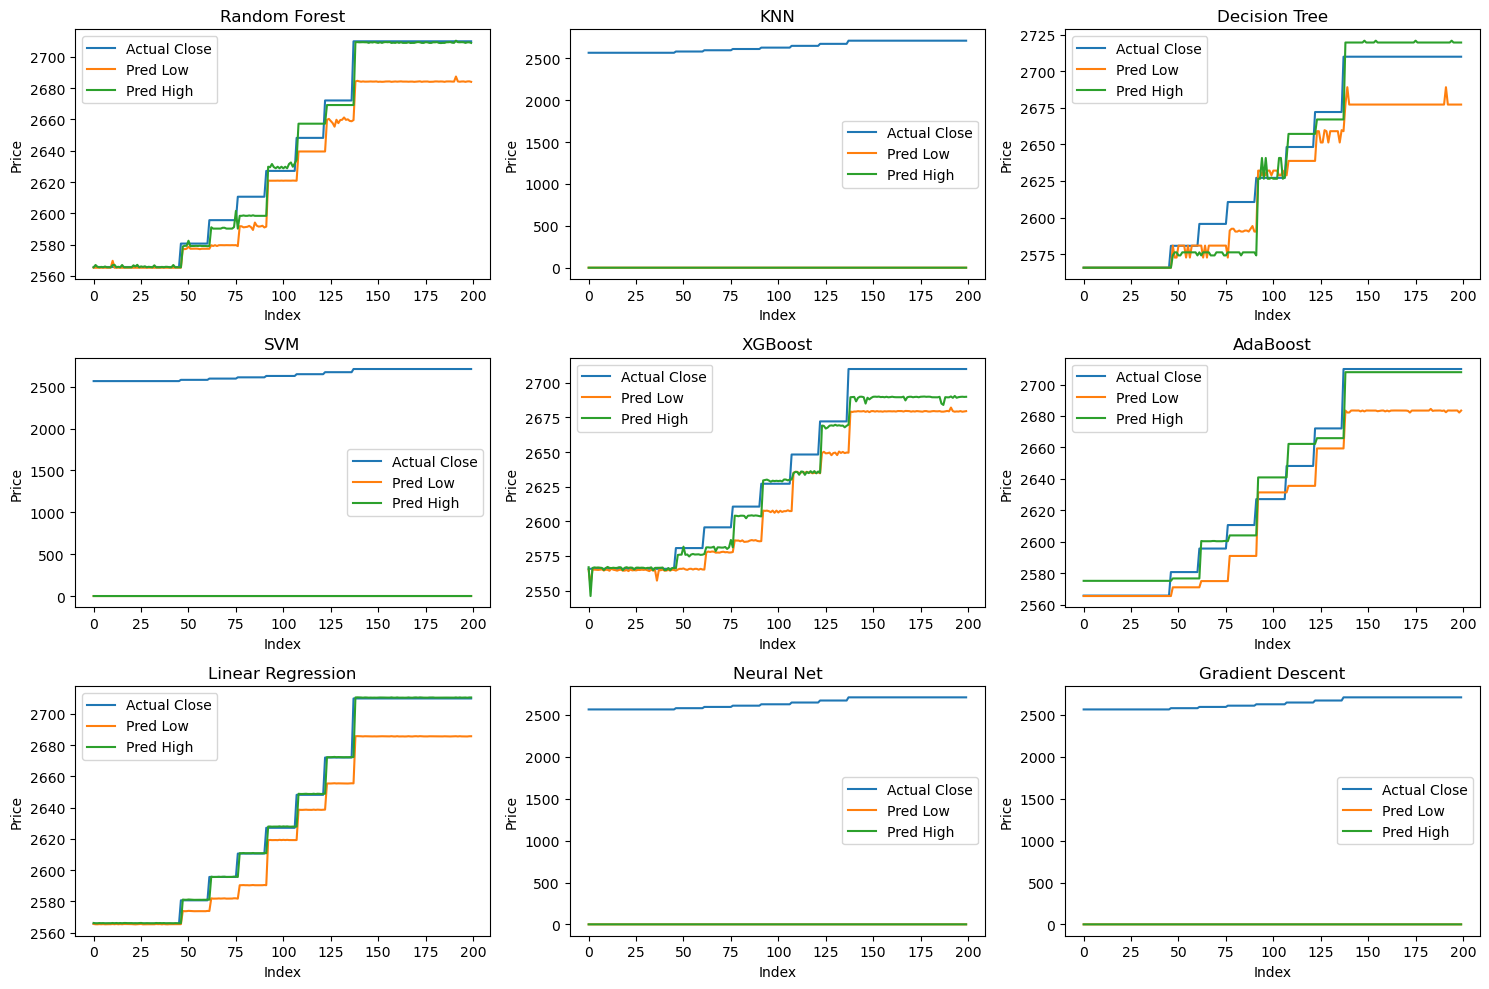

In [20]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

models = {
    "Random Forest": (pred_low_rf, pred_high_rf),
    "KNN": (pred_low_knn, pred_high_knn),
    "Decision Tree": (pred_low_dt, pred_high_dt),
    "SVM": (pred_low_svm, pred_high_svm),
    "XGBoost": (pred_low_xgb, pred_high_xgb),
    "AdaBoost": (pred_low_ada, pred_high_ada),
    "Linear Regression": (pred_low_lr, pred_high_lr),
    "Neural Net": (pred_low_nn, pred_high_nn),
    "Gradient Descent": (pred_low_gd, pred_high_gd)
}

# Metrics calculation
results = []

for name, (pred_low, pred_high) in models.items():
    low_r2 = r2_score(y_low_test, pred_low)
    high_r2 = r2_score(y_high_test, pred_high)
    mse_low = mean_squared_error(y_low_test, pred_low)
    mse_high = mean_squared_error(y_high_test, pred_high)
    
    # Range accuracy
    correct = ((y_close_test >= pred_low) & (y_close_test <= pred_high)).sum()
    range_acc = correct / len(y_close_test)
    
    results.append({
        "Model": name,
        "Low R2": low_r2,
        "High R2": high_r2,
        "MSE Low": mse_low,
        "MSE High": mse_high,
    })

df_results = pd.DataFrame(results)
print("\n===== MODEL COMPARISON =====")
print(df_results)

# visualization
plt.figure(figsize=(15,10))

for i, (name, (pred_low, pred_high)) in enumerate(models.items(), 1):
    plt.subplot(3,3,i)
    plt.plot(range(200), y_close_test[:200], label="Actual Close")
    plt.plot(range(200), pred_low[:200], label="Pred Low")
    plt.plot(range(200), pred_high[:200], label="Pred High")
    plt.title(name)
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()

plt.tight_layout()
plt.show()


KNN : 0.79%
##  Decision Tree: 24.34%

SVM: 0.36%
##  Random Forest :21.16%

Xgboost : 14.58%
##  Adaboost: 20.47%

Linear Regression :94.64%
##  Neural Network :48.9%

Gradient Descent : 0.0%
